# Using Genex to identify marker genes

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#import os
#os.chdir("/content/drive/My Drive/BIOML/HIMANI")

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from genex.filters.embedded import EmbeddedFilter
from genex.filters.mrmr import MRMRP
from genex.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs
from sklearn.feature_selection import RFE,RFECV, SelectKBest, f_classif,SelectKBest, mutual_info_classif,chi2
from genex.eval.evaluate import do_train_test
from genex.eval.cross_validation import  do_cross_validation_with_feature_selection,do_cross_validation

%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib inline

#from matplotlib.pyplot import plt
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
#mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [3]:
# ========== INPUTS ==========

mydata = 'GSE169755_norm'


data_file = './data/'+ mydata +'.csv'

deg_lf_file = './data/'+ mydata +'_DEGS.csv'
degs_file = './data/'+ mydata +'_DEGS.txt'   # If None, all genes will be considered.
out_file = './results/'+ mydata +'/fs_scores.csv'

is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
num_folds = 5 #2
num_runs = 5  #2
label = 'disease'

# feature selection
# num_features = 10 #20
# fsm = MRMRP(relevance_func= auc_relevance, redundancy_func=stats.pearsonr, num_features=num_features)

models = {
    "LinearSVC": LinearSVC(),
    "RidgeClassifier" : RidgeClassifier(alpha=1.0, max_iter=1000, solver='auto', tol=1e-3),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SGDClassifier" : SGDClassifier(loss="log_loss", penalty="l2", random_state=seed,learning_rate='optimal')
}


top_markers_to_viz = 10    # set to zero to visualize all potential markers. was 10

In [4]:
if degs_file is not None and os.path.exists(degs_file):
    DEGs = load_DEGs(degs_file)
    # Keep only genes that exist in the dataframe columns
    DEGs = [gene for gene in DEGs if gene in df.columns]
    lenDEGs = len(DEGs)
    print(f"{lenDEGs} DEGs loaded and matched!")
else:
    lenDEGs = 0
    print("No DEGs provided or file not found. Pipeline will consider all genes.")

# def load_DEGs(path): if oen from simple text file. this will clean blanck space and blank lines
#     with open(path, 'r') as f:
#         return [line.strip() for line in f if line.strip()]


No DEGs provided or file not found. Pipeline will consider all genes.


In [5]:
df = pd.read_csv(data_file,low_memory=False)
df=df.set_index('GeneId')
df = df.transpose()

#df2 = pd.read_csv(deg_lf_file)


print('Shape of {0} is {1}'.format(data_file, df.shape))
theData = df
y = df[label]
df =df.drop([label],axis=1)
df.head()

Shape of ./data/GSE169755_norm.csv is (12, 16332)


GeneId,Gene_653635,Gene_100996442,Gene_729737,Gene_102723897,Gene_112268260,Gene_100132287,Gene_113219467,Gene_100133331,Gene_105378580,Gene_643837,...,Gene_4538,Gene_4564,Gene_4575,Gene_4568,Gene_4540,Gene_4541,Gene_4556,Gene_4519,Gene_4576,Gene_4571
GSM5213623,1.912638,1.151930,1.381648,1.954344,1.242675,1.281803,2.821979,1.281803,1.151930,2.446541,...,5.999356,2.877591,2.272502,2.336376,5.364489,5.007669,3.020287,5.811568,2.953181,3.071773
GSM5213624,1.863293,1.270246,1.333850,1.964239,1.389318,1.333850,2.845333,1.414603,1.362469,2.508898,...,6.001369,2.460867,2.218955,2.195191,5.377041,5.045338,2.936247,5.829287,2.875255,3.270800
GSM5213625,2.022195,0.957856,0.881212,2.031190,0.732768,1.079602,2.792804,1.152715,1.195407,2.376791,...,5.475731,1.502872,1.215275,1.449664,4.848314,4.487190,1.880122,5.463328,2.094577,2.769590
GSM5213626,1.977081,1.233436,1.154518,2.059826,1.208689,1.154518,2.765757,1.233436,1.233436,2.325255,...,5.512973,1.568518,1.300194,1.509022,4.902666,4.613021,1.954818,5.481846,2.222491,2.550938
GSM5213627,1.856877,1.300591,1.175660,1.939063,1.414529,1.230014,2.624852,1.254837,0.476814,2.139421,...,5.608461,1.908029,1.543620,1.518066,4.855469,4.692553,2.052621,5.546280,2.273699,2.361268


In [6]:
# Load and process data
df = pd.read_csv(data_file, low_memory=False)
df = df.set_index('GeneId').transpose()
print(f"Shape of {data_file} is {df.shape}")

y = df[label]

if lenDEGs > 0:
    df = df[DEGs]
else:
    df = df.drop([label], axis=1)

print(f"Shape (Within DEGs) of {data_file} is {df.shape}")
names = df.columns
X = df.values


Shape of ./data/GSE169755_norm.csv is (12, 16332)
Shape (Within DEGs) of ./data/GSE169755_norm.csv is (12, 16331)


In [7]:
# Normalize per sample?
if is_normalize_samples:
    X = norm_filter.fit_transform(X.T, y).T
    print('Samples Normalized..')
# Normalize per sample
elif is_normalize_columns:
    X = norm_filter.fit_transform(X, y)
    print('Genes Normalized..')
else:
    print('No normalization used..')

Genes Normalized..


ACC	Sn	Sp	MCC	AUC
[0.97333333 1.         0.96       0.96       0.98      ]
ACC	Sn	Sp	MCC	AUC
[0.96 0.98 0.96 0.94 0.97]
ACC	Sn	Sp	MCC	AUC
[0.97333333 1.         0.96       0.96       1.        ]
ACC	Sn	Sp	MCC	AUC
[0.72666667 0.68       0.82       0.5        0.98      ]


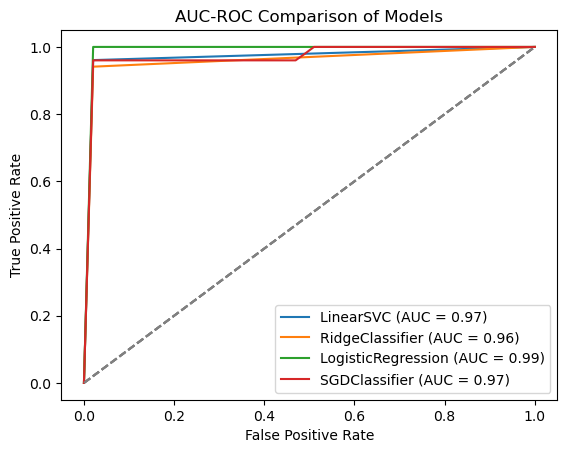

In [7]:
from sklearn.metrics import roc_curve, auc


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_name, model in models.items():
        tprs, aucs, mean_fpr = [], [], np.linspace(0, 1)
        fsm=RFE(estimator=model,n_features_to_select=20,step=200)
        res2,scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
        print('ACC\tSn\tSp\tMCC\tAUC')
        print(res2['metrics'])
        #print(res2)
        fpr = res2['fpr']
        tpr = res2['tpr']
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Comparison of Models')
    plt.legend()
    plt.show()


In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    res2, scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
    print('ACC\tSn\tSp\tMCC\tAUC')
    print(res2['metrics'])
    #print(scores)

    dict = {'feature': names, 'score': scores}
    df_score = pd.DataFrame(dict, columns=['feature', 'score'],index=None)
    df_score[df_score['score']>0].sort_values(by='score',ascending=False)


ACC	Sn	Sp	MCC	AUC
[0.79333333 0.8        0.8        0.61237604 0.93      ]


In [8]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume you already have these from before
# df = your dataframe with gene expression (samples x genes)
# y = label vector (same length as number of samples)
# names = list of gene names (column names of df)
# X = df.values (gene expression matrix)

# === 1. Train both models ===
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
log = LogisticRegression(random_state=42, max_iter=1000)

sgd.fit(X, y)
log.fit(X, y)

# === 2. Get absolute coefficient scores for genes ===
sgd_scores = np.abs(sgd.coef_).flatten()
log_scores = np.abs(log.coef_).flatten()

# === 3. Normalize both scores between 0 and 1 ===
scaler = MinMaxScaler()
sgd_norm = scaler.fit_transform(sgd_scores.reshape(-1, 1)).flatten()
log_norm = scaler.fit_transform(log_scores.reshape(-1, 1)).flatten()

# === 4. Combine scores ===
combined_score = sgd_norm + log_norm

# === 5. Rank genes ===
top_indices = np.argsort(combined_score)[::-1]  # descending order
top_genes = [names[i] for i in top_indices]
top_scores = [combined_score[i] for i in top_indices]

# === 6. Display top N genes ===
N = 20
print(f"\nTop {N} Genes based on combined score:\n")
for i in range(N):
    print(f"{i+1:2d}. {top_genes[i]} — Score: {top_scores[i]:.4f}")



Top 20 Genes based on combined score:

 1. Gene_107987087 — Score: 1.9081
 2. Gene_9910 — Score: 1.8291
 3. Gene_771 — Score: 1.7403
 4. Gene_344758 — Score: 1.6963
 5. Gene_51555 — Score: 1.6949
 6. Gene_80036 — Score: 1.6691
 7. Gene_481 — Score: 1.6636
 8. Gene_6570 — Score: 1.6572
 9. Gene_107984616 — Score: 1.6432
10. Gene_4644 — Score: 1.6387
11. Gene_284716 — Score: 1.6371
12. Gene_105378941 — Score: 1.6312
13. Gene_114800 — Score: 1.6295
14. Gene_160760 — Score: 1.6170
15. Gene_105374898 — Score: 1.6169
16. Gene_1285 — Score: 1.5696
17. Gene_1191 — Score: 1.5633
18. Gene_253782 — Score: 1.5621
19. Gene_283514 — Score: 1.5604
20. Gene_83698 — Score: 1.5398
